<a href="https://colab.research.google.com/github/Lupama2/IntroCUDA/blob/main/GoogleColab/ICNPG_SumaVectores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de performance de suma de vectores

Vamos a comparar los tiempos de ejecución de la suma de vectores en CPU vs los de GPU teniendo en cuenta el tiempo de ejecución del kernel, y el tiempo total, incluyendo los tiempos de copia H2D y D2H.

Usaremos solo el cronómetro para CPU, pero nos aseguraremos con CudaDeviceSynchronize() que la GPU haya terminado su trabajo.

In [1]:
#@title Que GPU nos toco?

!nvidia-smi

Tue May  9 12:12:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Cronómetro para CPU

%%writefile cpu_timer.h

#include <ctime>

// estructuras para el timer en CPU ////////////////////

struct timespec diff(timespec start, timespec end)
{
        timespec temp;
       	if ((end.tv_nsec-start.tv_nsec)<0) {
                temp.tv_sec = end.tv_sec-start.tv_sec-1;
                temp.tv_nsec = 1000000000+end.tv_nsec-start.tv_nsec;
        } else {
                temp.tv_sec = end.tv_sec-start.tv_sec;
                temp.tv_nsec = end.tv_nsec-start.tv_nsec;
        }
        return temp;
}
struct cpu_timer{
        struct timespec time1, time2;
	      double ms_elapsed;

        cpu_timer(){
        	tic();
        }
       ~cpu_timer(){}

        void tic(){
                clock_gettime(CLOCK_PROCESS_CPUTIME_ID, &time1);
        }
        double tac(){
                clock_gettime(CLOCK_PROCESS_CPUTIME_ID, &time2);
                return(ms_elapsed=elapsed());
        }
        double elapsed(){
            return (double)diff(time1,time2).tv_sec*1000 + (double)diff(time1,time2).tv_nsec*0.000001;
        }
};


Writing cpu_timer.h


In [ ]:
#@title Comparación de tiempos: [copias H2D y D2H + kernel] vs [kernel]

%%writefile sumavec.cu

#include <stdio.h>
#include <assert.h>
#include <stdlib.h>
#include <fstream>
#include "cpu_timer.h"

#define SIZE	1024

// kernel
__global__ void VectorAdd(int *a, int *b, int *c, int n)
{
	// indice de thread mapeado a indice de array 
	int i = blockIdx.x * blockDim.x + threadIdx.x;
	if (i < n)
		c[i] = a[i] + b[i];
}


// kernel
void VectorAddCPU(int *a, int *b, int *c, int n)
{
	for(int i=0;i<n;i++){
		c[i] = a[i] + b[i];
	}
}


int main(int argc, char **argv)
{
	int N;
	
	if(argc==2) N=atoi(argv[1]);
	else N=SIZE;

	// punteros a memoria de host
	int *a, *b, *c;

	// punteros a memoria de device
	int *d_a, *d_b, *d_c;

	// alocacion memoria de host
	a = (int *)malloc(N*sizeof(int));
	b = (int *)malloc(N*sizeof(int));
	c = (int *)malloc(N*sizeof(int));

	// alocacion memoria de device
	cudaMalloc( &d_a, N*sizeof(int));
	cudaMalloc( &d_b, N*sizeof(int));
	cudaMalloc( &d_c, N*sizeof(int));

	// inicializacion arrays de host
	for( int i = 0; i < N; ++i )
	{
		a[i] = i;
		b[i] = i;
		c[i] = 0;
	}

	// cronometro 1
	cpu_timer Reloj1;
	Reloj1.tic();

	// copia de host a device
	cudaMemcpy( d_a, a, N*sizeof(int), cudaMemcpyHostToDevice );
	cudaMemcpy( d_b, b, N*sizeof(int), cudaMemcpyHostToDevice );


	// grilla de threads suficientemente grande...
	dim3 nThreads(256);
	dim3 nBlocks((N + nThreads.x - 1) / nThreads.x);
	// suma paralela en el device


	// cronometro 2
	cpu_timer Reloj2;
	Reloj2.tic();

	VectorAdd<<< nBlocks, nThreads >>>(d_a, d_b, d_c, N); // kernel

  cudaDeviceSynchronize(); // espera a que termine el kernel (sync GPU-CPU)

  double t2=Reloj2.tac(); // tiempo solo kernel

	// copia (solo del resultado) del device a host
	cudaMemcpy( c, d_c, N*sizeof(int), cudaMemcpyDeviceToHost );

  double t1=Reloj1.tac(); // tiempo copias H2D, kernel, copia D2H

	cpu_timer Reloj3;
	Reloj3.tic();
	VectorAddCPU(a,b,c,N);
	double t3=Reloj3.tac();

	// milisegundos transcurridos
	printf("VectorAdd<<< %d, %d >>>, N= %d t1= %lf ms t2= %lf ms t3= %lf \n", nBlocks.x, nThreads.x, N, t1, t2, t3);

  std::ofstream fout("tiempos.csv",std::ios_base::app);
  fout << N << "," << t1 << "," << t2 << "," << t3 << std::endl;

	// verificacion del resultado
	for( int i = 0; i < N; ++i){
		//printf("c[%d] = %d\n", i, c[i]);
		assert(c[i]==2*i);
	}

	// liberacion memoria de host
	free(a);
	free(b);
	free(c);

	// liberacion memoria de device
	cudaFree(d_a);
	cudaFree(d_b);
	cudaFree(d_c);

	return 0;
}


Overwriting sumavec.cu


In [ ]:
#@title Borramos el archivo de tiempos viejos y compilamos

!rm tiempos.csv; nvcc sumavec.cu -o sumavec

rm: cannot remove 'tiempos.csv': No such file or directory


In [ ]:
#@title Ejecutamos el programa para muchos N 

#usamos comandos de shell para lanzar muchas veces el ejecutable

!for((i=8;i<24;i++)); do N=$((2**$i)); ./sumavec $N; done

VectorAdd<<< 1, 256 >>>, N= 256 t1= 0.074001 ms t2= 0.027844 ms t3= 0.001260 
VectorAdd<<< 2, 256 >>>, N= 512 t1= 0.067619 ms t2= 0.023217 ms t3= 0.001972 
VectorAdd<<< 4, 256 >>>, N= 1024 t1= 0.076340 ms t2= 0.032965 ms t3= 0.003986 
VectorAdd<<< 8, 256 >>>, N= 2048 t1= 0.069097 ms t2= 0.021322 ms t3= 0.007137 
VectorAdd<<< 16, 256 >>>, N= 4096 t1= 0.079915 ms t2= 0.022995 ms t3= 0.013669 
VectorAdd<<< 32, 256 >>>, N= 8192 t1= 0.096586 ms t2= 0.024730 ms t3= 0.025112 
VectorAdd<<< 64, 256 >>>, N= 16384 t1= 0.139187 ms t2= 0.024579 ms t3= 0.050195 
VectorAdd<<< 128, 256 >>>, N= 32768 t1= 0.193384 ms t2= 0.027209 ms t3= 0.097193 
VectorAdd<<< 256, 256 >>>, N= 65536 t1= 0.284855 ms t2= 0.038962 ms t3= 0.207489 
VectorAdd<<< 512, 256 >>>, N= 131072 t1= 0.517411 ms t2= 0.057029 ms t3= 0.443935 
VectorAdd<<< 1024, 256 >>>, N= 262144 t1= 1.077789 ms t2= 0.108837 ms t3= 0.820227 
VectorAdd<<< 2048, 256 >>>, N= 524288 t1= 1.651809 ms t2= 0.118496 ms t3= 1.750768 
VectorAdd<<< 4096, 256 >>>, N=

In [ ]:
!./sumavec 257

VectorAdd<<< 2, 256 >>>, N= 257 t1= 0.070534 ms t2= 0.024503 ms t3= 0.001279 


In [ ]:
#@title verifiquemos que el file de datos este bien

!cat tiempos.csv

256,0.074001,0.027844,0.00126
512,0.067619,0.023217,0.001972
1024,0.07634,0.032965,0.003986
2048,0.069097,0.021322,0.007137
4096,0.079915,0.022995,0.013669
8192,0.096586,0.02473,0.025112
16384,0.139187,0.024579,0.050195
32768,0.193384,0.027209,0.097193
65536,0.284855,0.038962,0.207489
131072,0.517411,0.057029,0.443935
262144,1.07779,0.108837,0.820227
524288,1.65181,0.118496,1.75077
1048576,2.96892,0.136094,3.34006
2097152,5.80094,0.18601,7.68888
4194304,12.0676,0.275358,13.0916
8388608,22.5834,0.47654,26.9506


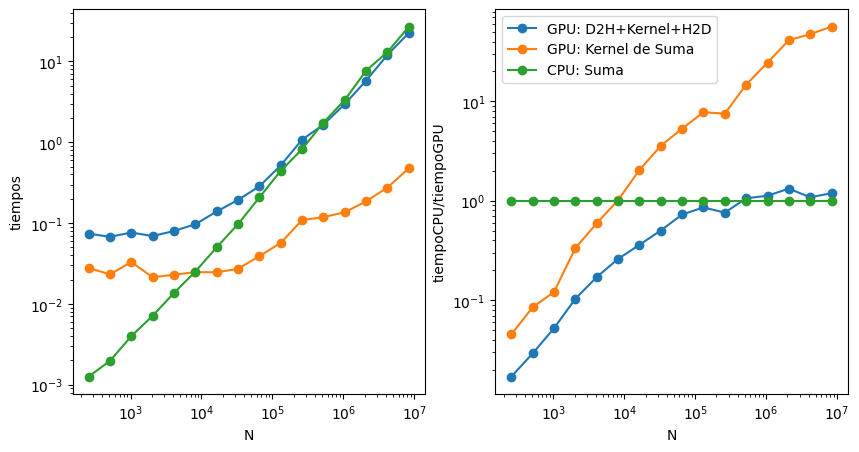

In [ ]:
#@title Graficos de lso 3 tiempos y aceleracion 

import matplotlib.pyplot as plt
import pandas as pd

# Read the data from file
data = pd.read_csv('tiempos.csv', header=None)

# Set the x-axis and y-axis values
x = data.iloc[:, 0]  # assuming the first column is x
y1 = data.iloc[:, 1]  # assuming the second column is y1
y2 = data.iloc[:, 2]  # assuming the third column is y2
y3 = data.iloc[:, 3]  # assuming the third column is y3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the data
ax1.loglog(x, y1, "-o", label='GPU: D2H+Kernel+H2D')
ax1.loglog(x, y2, "-o", label='GPU: Kernel de Suma')
ax1.loglog(x, y3, "-o", label='CPU: Suma')

ax2.loglog(x, y3/y1, "-o", label='GPU: D2H+Kernel+H2D')
ax2.loglog(x, y3/y2, "-o", label='GPU: Kernel de Suma')
ax2.loglog(x, y3/y3, "-o", label='CPU: Suma')



# Add labels and title
ax1.set_xlabel('N')
ax1.set_ylabel('tiempos')
ax2.set_xlabel('N')
ax2.set_ylabel('tiempoCPU/tiempoGPU')
#plt.title('')

# Add legend
plt.legend()

# Display the plot
plt.show()